In [1]:
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import pearsonr

In [2]:
# Read the training data into Pandas Dataframe
with open('data/train.jsonl', 'r', encoding='utf-8') as f:
    json_string = f.read()
train_df = pd.read_json(StringIO(json_string), lines=True)

# Read the development data into Pandas Dataframe
with open('data/dev.jsonl', 'r', encoding='utf-8') as f:
    json_string = f.read()
dev_df = pd.read_json(StringIO(json_string), lines=True)

# Read the test data into Pandas Dataframe
with open('data/test.jsonl', 'r', encoding='utf-8') as f:
    json_string = f.read()
test_df = pd.read_json(StringIO(json_string), lines=True)

Chi squared test is performed to select categorical feature which are significant in contributing to prediction of Supreme Court decisions. 

In [4]:
# A function which perform chi_squared test on feature columns in dataframe
def chi_square_test(dataframe, target_variable, feature_columns):
    results = []
    for column in feature_columns:
        if column in dataframe.columns and column != target_variable:
            # Create a contingency table
            contingency_table = pd.crosstab(dataframe[column], dataframe[target_variable])
            # Perform Chi-square test
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            results.append({
                'Feature': column,
                'Chi-square': chi2,
                'P-value': p,
                'Degrees of Freedom': dof
            })
    results_df = pd.DataFrame(results)
    return results_df

feature_list = ['title', 'petitioner', 'respondent', 'petitioner_state', 'respondent_state', 'petitioner_category', 'respondent_category', 'issue_area']  # List of feature columns to analyze
results_df = chi_square_test(train_df, 'successful_appeal', feature_list)

# Print the results as a table
print(results_df)

               Feature   Chi-square       P-value  Degrees of Freedom
0                title  4541.810253  4.562164e-01                4532
1           petitioner  3573.083413  3.171988e-02                3418
2           respondent  3371.895135  4.633024e-01                3365
3     petitioner_state    50.219875  6.923689e-01                  56
4     respondent_state    66.277534  1.418415e-01                  55
5  petitioner_category   409.835337  2.565860e-10                 246
6  respondent_category   396.692854  2.266768e-11                 227
7           issue_area    62.214130  4.780718e-08                  14


Check whether there is class imbalanced in the dataset

successful_appeal
1    63.508239
0    36.491761
Name: proportion, dtype: float64


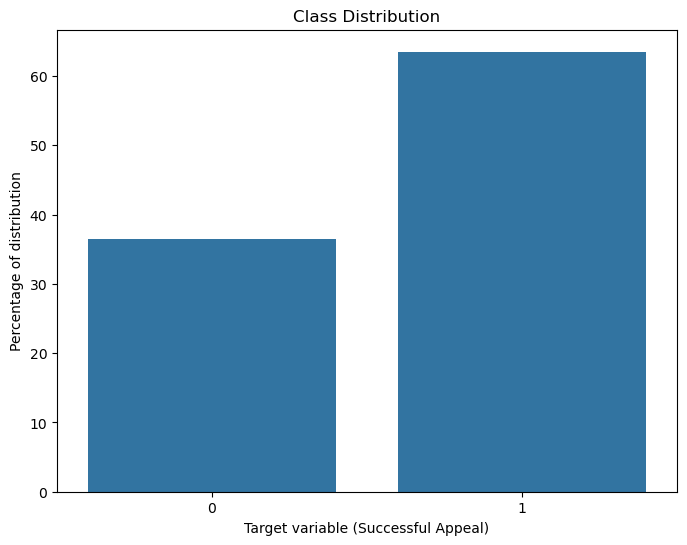

In [6]:
# Print the class distibution
class_distribution = train_df['successful_appeal'].value_counts(normalize=True) * 100
print(class_distribution)

# Plotting the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Target variable (Successful Appeal)')
plt.ylabel('Percentage of distribution')
plt.show()

For RQ1, engineer a new feature, argument month

In [8]:
# Convert 'argument_date' to datetime
train_df['argument_date'] = pd.to_datetime(train_df['argument_date'])
# Extract the month from 'argument_date'
train_df['argument_month'] = train_df['argument_date'].dt.month

# Convert 'argument_date' to datetime
dev_df['argument_date'] = pd.to_datetime(dev_df['argument_date'])
# Extract the month from 'argument_date'
dev_df['argument_month'] = dev_df['argument_date'].dt.month

# Convert 'argument_date' to datetime
test_df['argument_date'] = pd.to_datetime(test_df['argument_date'])
# Extract the month from 'argument_date'
test_df['argument_month'] = test_df['argument_date'].dt.month

# Fill missing values in argument_month using the most frequent month
most_frequent_month = test_df['argument_month'].mode()[0]
test_df['argument_month'] = test_df['argument_month'].fillna(most_frequent_month)


For RQ2, engineer a new feature, length of hearing

In [10]:
# Calculate length of court hearing 
train_df['decision_date'] = pd.to_datetime(train_df['decision_date'])
train_df['hearing_length'] = (train_df['decision_date'] - train_df['argument_date']).dt.days

# Calculate length of court hearing 
dev_df['decision_date'] = pd.to_datetime(dev_df['decision_date'])
dev_df['hearing_length'] = (dev_df['decision_date'] - dev_df['argument_date']).dt.days

# Calculate length of court hearing 
test_df['decision_date'] = pd.to_datetime(test_df['decision_date'])
test_df['hearing_length'] = (test_df['decision_date'] - test_df['argument_date']).dt.days

# Fill missing values in argument_month using the mean court_hearing_length
mean_court_hearing = test_df['hearing_length'].mean()
test_df['hearing_length'] = test_df['hearing_length'].fillna(mean_court_hearing)


For RQ3, engineer a new feature, the percentage of female justice in a court case

In [12]:
# A function for calculating the percentage of female justice in a court case
def justices (dataframe): 
    percent_female_list = []
    
    for row in dataframe['justices']:
        total_justices = 0
        female_justices = 0
        
        for justice in row:
            total_justices += 1
            
            if justice['gender'].lower() == 'female':
                female_justices += 1
                
                
        percent_female = (female_justices / total_justices) * 100 if total_justices > 0 else 0
        percent_female_list.append(percent_female)

    dataframe['percent_female'] = percent_female_list
    return dataframe
        
train_df = justices(train_df)
dev_df = justices(dev_df)
test_df = justices(test_df)


In [13]:
# Add the embeddings of court hearing to existing dataframe
embeddings = np.load('data/sembed/train.npy')
train_df['embeddings'] = list(embeddings)
embedding_df = train_df['embeddings'].apply(pd.Series)
embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]
train_df = pd.concat([train_df, embedding_df], axis=1)

# Add the embeddings of court hearing to existing dataframe
embeddings = np.load('data/sembed/dev.npy')
dev_df['embeddings'] = list(embeddings)
embedding_df = dev_df['embeddings'].apply(pd.Series)
embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]
dev_df = pd.concat([dev_df, embedding_df], axis=1)

# Add the embeddings of court hearing to existing dataframe
embeddings = np.load('data/sembed/test.npy')
test_df['embeddings'] = list(embeddings)
embedding_df = test_df['embeddings'].apply(pd.Series)
embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]
test_df = pd.concat([test_df, embedding_df], axis=1)

Perform one hot encoding on categorical data

In [15]:
# Initialize OneHotEncoder which ignore unseen category during training
encoder = OneHotEncoder(handle_unknown='ignore')
columns = ['respondent_category', 'petitioner_category','issue_area']
encoder.fit(train_df[columns])

# Perform one hot encoding on each dataset 
train_encoded = encoder.transform(train_df[columns]).toarray()
dev_encoded = encoder.transform(dev_df[columns]).toarray()
test_encoded = encoder.transform(test_df[columns]).toarray() 

# Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(columns))
dev_encoded_df = pd.DataFrame(dev_encoded, columns=encoder.get_feature_names_out(columns))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(columns))

# Add them to existing dataframes
train_df = pd.concat([train_df, train_encoded_df], axis=1)
dev_df = pd.concat([dev_df, dev_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [16]:
# Split data into feature and target variables
# training set
train_x_RQ1 = train_df.drop(columns=['case_id','title', 'petitioner_state', 'respondent_state', 'petitioner_category', 'respondent_category','issue_area',
                                 'petitioner', 'respondent', 'argument_date', 'court_hearing','decision_date', 'majority_ratio', 'chief_justice', 
                                 'justices', 'successful_appeal', 'embeddings', 'year', 'hearing_length', 'percent_female'])
train_y = train_df['successful_appeal']

# development set
dev_x_RQ1 = dev_df.drop(columns=['case_id','title', 'petitioner_state', 'respondent_state', 'petitioner_category', 'respondent_category','issue_area',
                                 'petitioner', 'respondent', 'argument_date', 'court_hearing','decision_date', 'majority_ratio', 'chief_justice', 
                                 'justices', 'successful_appeal', 'embeddings', 'year', 'hearing_length', 'percent_female'])
dev_y = dev_df['successful_appeal']

# testing set
test_x_RQ1 = test_df.drop(columns=['case_id','title', 'petitioner_state', 'respondent_state', 'petitioner_category', 'respondent_category','issue_area',
                                 'petitioner', 'respondent', 'argument_date', 'court_hearing','decision_date', 'majority_ratio', 'chief_justice', 
                                 'justices', 'embeddings', 'year', 'hearing_length', 'percent_female'])

# Select top 200 features
selector = SelectKBest(score_func=f_classif, k=200)  
selector.fit(train_x_RQ1, train_y)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)
selected_features = train_x_RQ1.columns[selected_indices]

# print("Selected Features:", selected_features)

train_x_RQ1 = train_x_RQ1[selected_features]
dev_x_RQ1 = dev_x_RQ1[selected_features]
test_x_RQ1 = test_x_RQ1[selected_features]

# Perform normalisation
scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x_RQ1)
dev_x_scaled = scaler.transform(dev_x_RQ1)
test_x_scaled = scaler.transform(test_x_RQ1)

In [17]:
# RQ1
# Use baseline model for predicting decisions using information available prior or during court hearing
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(train_x_scaled, train_y)

# Calculate accuracy & f1 score for training set
pred_y = baseline.predict(train_x_scaled)
accuracy = accuracy_score(train_y, pred_y)
print(f'Accuracy for training set: {accuracy:.4f}')
f1 = f1_score(train_y, pred_y)
print(f'F1 score for training set: {f1:.4f}')

# Calculate accuracy & f1 score for validation set
pred_y = baseline.predict(dev_x_scaled)
accuracy = accuracy_score(dev_y, pred_y)
print(f'Accuracy for validation set: {accuracy:.4f}')
f1 = f1_score(dev_y, pred_y)
print(f'F1 score for validation set: {f1:.4f}')

# Predict the label using baseline model
pred_y = baseline.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file
output_df.to_csv('prediction_baseline.csv', index=False)

Accuracy for training set: 0.6351
F1 score for training set: 0.7768
Accuracy for validation set: 0.6360
F1 score for validation set: 0.7775


The following is for research question 1. 
RQ1. Does the information available prior to or during hearing help predict Supreme Court decisions? 

Using same features, we compare the performance of baseline model, KNN and Logistic Regression in predicting Supreme Court decisions. If KNN and Logistic Regression outperform baseline model, the information are useful in predicting the decisions.

Both KNN and Logistic Regression use training set for training. Hyperparameter search is performed to find the best hyperparameters that yield the highest accuracy and f1 score. The tuned models are then trained on the combined training and validation sets. The refined models are evaluated using the Kaggle competition results, with the model achieving highest accuracy selected as the final model. 

In [19]:
# Perform hyperparameter search for KNN
knn = KNeighborsClassifier()

# List to store results of hyperparameter search
results = []

# Define the parameter range
n_neighbors_range = list(range(1, 70)) 
metrics = ['euclidean', 'hamming', 'manhattan']
weights = ['uniform', 'distance']

# Store accuracies for training and development set for drawing learning curve
train_accuracies = []
dev_accuracies = []

# Iterate through all combinations of n_neighbors and metric
for n_neighbors in n_neighbors_range:
    for metric in metrics:
         for weight in weights: 
            knn.set_params(n_neighbors=n_neighbors, metric=metric, weights=weight)
            knn.fit(train_x_scaled, train_y)

            # Predict on the validation set
            dev_pred_y = knn.predict(dev_x_scaled)
            
            # Calculate accuracy and f1 score
            dev_accuracy = accuracy_score(dev_y, dev_pred_y)
            f1 = f1_score(dev_y, dev_pred_y)

            # Append accuracies to lists if fulfil the condition
            if (weight == 'distance' and metric == 'euclidean'):
                train_pred_y = knn.predict(train_x_scaled)
                train_accuracy = accuracy_score(train_y, train_pred_y)
                 
                train_accuracies.append(train_accuracy)
                dev_accuracies.append(dev_accuracy)
            
            # Store the results
            results.append((n_neighbors, metric, weight, dev_accuracy, f1))

# Find the best parameters based on validation set using f1
best_n_neighbours, best_metric, best_weight, best_accuracy, best_f1 = max(results, key=lambda x: x[4])
print(f"Best hyperparameters using f1: n_neighbors={best_n_neighbours}, metric='{best_metric}', weight='{best_weight}'")
print(f"Validation set accuracy: {best_accuracy:.4f}%")
print(f"Validation set f1: {best_f1:.4f}%")

# Find the best parameters based on validation set using accuracy
best_n_neighbours, best_metric, best_weight, best_accuracy, best_f1 = max(results, key=lambda x: x[3])
print(f"Best hyperparameters using accuracy: n_neighbors={best_n_neighbours}, metric='{best_metric}', weight='{best_weight}'")
print(f"Validation set accuracy: {best_accuracy:.4f}%")
print(f"Validation set f1: {best_f1:.4f}%")



Best hyperparameters using f1: n_neighbors=57, metric='hamming', weight='uniform'
Validation set accuracy: 0.6464%
Validation set f1: 0.7811%
Best hyperparameters using accuracy: n_neighbors=20, metric='euclidean', weight='distance'
Validation set accuracy: 0.6638%
Validation set f1: 0.7734%


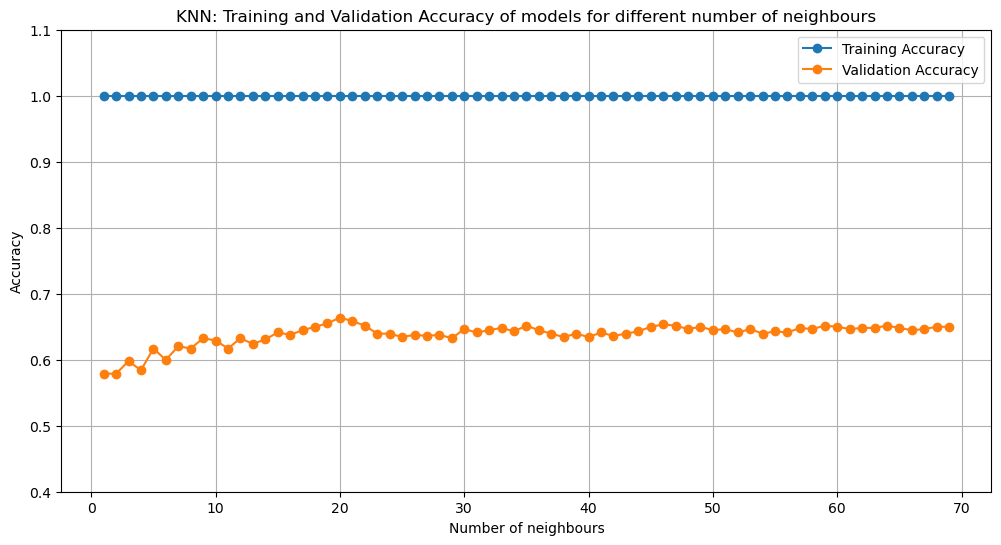

In [20]:
# Plot the learning curve for KNN
plt.figure(figsize=(12, 6))
plt.plot(n_neighbors_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_neighbors_range, dev_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.title('KNN: Training and Validation Accuracy of models for different number of neighbours')
plt.ylim(0.4, 1.1)
plt.legend()
plt.grid(True)
plt.show()

Accuracy for training set: 0.6520
F1 score for training set: 0.7821
Accuracy for validation set: 0.6464
F1 score for validation set: 0.7811


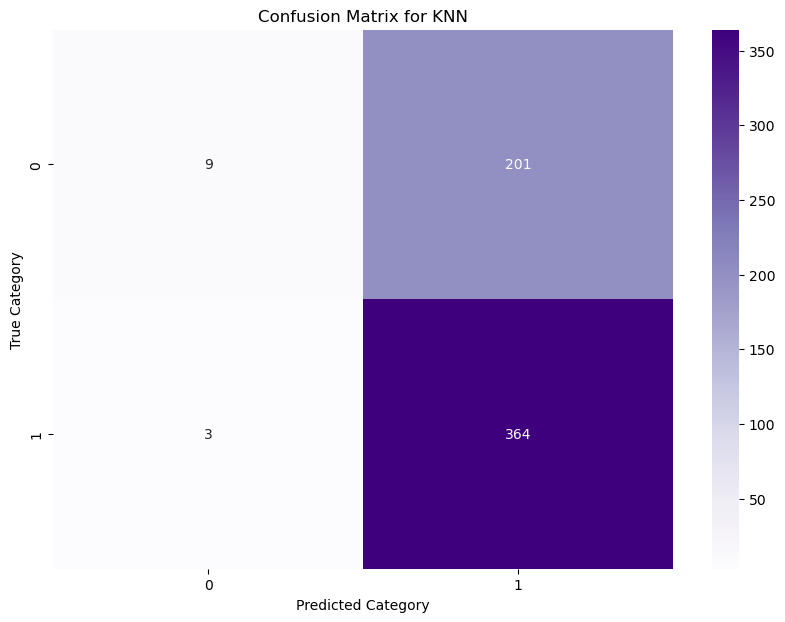

In [21]:
# Use KNN with best hyperparameters according to f1 score for predicting decisions using information available prior or during court hearing
knn_classifier = KNeighborsClassifier(n_neighbors=57, metric='hamming', weights='uniform')

# Train the k-NN classifier on the training data
knn_classifier.fit(train_x_scaled, train_y)

# Make predictions on the training set
pred_y = knn_classifier.predict(train_x_scaled)

# Evaluate the model using accuracy and f1 score for training set
accuracy_knn = accuracy_score(train_y, pred_y)
print(f'Accuracy for training set: {accuracy_knn:.4f}')
f1_knn = f1_score(train_y, pred_y)
print(f'F1 score for training set: {f1_knn:.4f}')

# Make predictions on the validation set
pred_y = knn_classifier.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score for validation set
accuracy_knn = accuracy_score(dev_y, pred_y)
print(f'Accuracy for validation set: {accuracy_knn:.4f}')
f1_knn = f1_score(dev_y, pred_y)
print(f'F1 score for validation set: {f1_knn:.4f}')

# Compute confusion matrix
matrix = confusion_matrix(dev_y, pred_y)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Purples", xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix for KNN')
plt.show()

# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ1, dev_x_RQ1], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
knn_classifier.fit(tune_x_scaled, tune_y)

# Make predictions on the test set
pred_y = knn_classifier.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_best_knn_f1.csv', index=False)

Accuracy for training set: 1.0000
F1 score for training set: 1.0000
Accuracy for validation set: 0.6638
F1 score for validation set: 0.7734


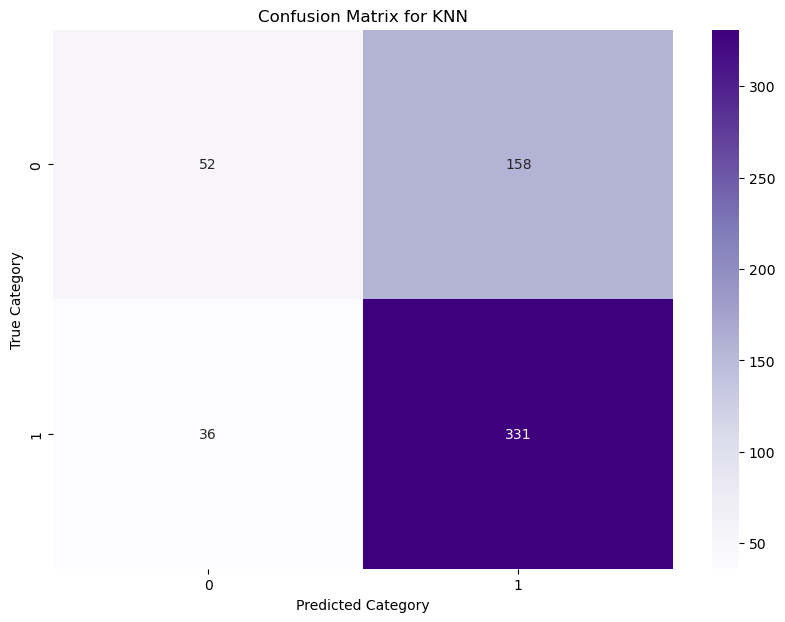

In [22]:
# Use KNN with best hyperparameters according to accuracy for predicting decisions using information available prior or during court hearing
knn_classifier = KNeighborsClassifier(n_neighbors=20, metric='euclidean', weights='distance')

# Train the k-NN classifier on the training data
knn_classifier.fit(train_x_scaled, train_y)

# Make predictions on the training set
pred_y = knn_classifier.predict(train_x_scaled)

# Evaluate the model using accuracy and f1 score for training set
accuracy_knn = accuracy_score(train_y, pred_y)
print(f'Accuracy for training set: {accuracy_knn:.4f}')
f1_knn = f1_score(train_y, pred_y)
print(f'F1 score for training set: {f1_knn:.4f}')

# Make predictions on the validation set
pred_y = knn_classifier.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score for validation set
accuracy_knn = accuracy_score(dev_y, pred_y)
print(f'Accuracy for validation set: {accuracy_knn:.4f}')
f1_knn = f1_score(dev_y, pred_y)
print(f'F1 score for validation set: {f1_knn:.4f}')

# Compute confusion matrix
matrix = confusion_matrix(dev_y, pred_y)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Purples", xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix for KNN')
plt.show()

# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ1, dev_x_RQ1], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
knn_classifier.fit(tune_x_scaled, tune_y)

# Make predictions on the test set
pred_y = knn_classifier.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_best_knn_accuracy.csv', index=False)

In [23]:
warnings.filterwarnings("ignore", category=UserWarning)
# Perform hyperparameter search for Logistic Regression
model = LogisticRegression()

# List to store results
results = []

# Define the parameter range
max_iters = list(range(1, 100)) 
c_values = [0.1, 1, 0.01]
solvers = ['lbfgs', 'newton-cholesky', 'liblinear']

# Store accuracies for training and development set for drawing learning curve
train_accuracies = []
dev_accuracies = []

# Iterate through all combinations of n_neighbors and metric
for max_iter in max_iters:
    for c in c_values:
         for solver in solvers: 
            model.set_params(max_iter=max_iter, C=c, solver=solver)
            model.fit(train_x_scaled, train_y)
    
            # Predict on the validation set
            pred_y = model.predict(dev_x_scaled)
            
            # Calculate accuracy and f1 score
            dev_accuracy = accuracy_score(dev_y, pred_y)
            f1 = f1_score(dev_y, pred_y)

             # Append accuracies to lists if fulfils the condition
            if (c == 1 and solver == 'lbfgs'):
                train_pred_y = model.predict(train_x_scaled)
                train_accuracy = accuracy_score(train_y, train_pred_y)
                
                train_accuracies.append(train_accuracy)
                dev_accuracies.append(dev_accuracy)
                
            # Store the results
            results.append((max_iter, c, solver, dev_accuracy, f1))

# Find the best parameters based on validation set using f1
best_max_iter, best_c, best_solver, best_accuracy, best_f1 = max(results, key=lambda x: x[4])
print(f"Best hyperparameters using f1: max_iter={best_max_iter}, c='{best_c}', solver='{best_solver}'")
print(f"Validation set accuracy: {best_accuracy:.4f}%")
print(f"Validation set f1: {best_f1:.4f}%")

# Find the best parameters based on validation set using accuracy
best_max_iter, best_c, best_solver, best_accuracy, best_f1 = max(results, key=lambda x: x[3])
print(f"Best hyperparameters using accuracy: max_iter={best_max_iter}, c='{best_c}', solver='{best_solver}'")
print(f"Validation set accuracy: {best_accuracy:.4f}%")
print(f"Validation set f1: {best_f1:.4f}%")


Best hyperparameters using f1: max_iter=6, c='0.01', solver='lbfgs'
Validation set accuracy: 0.6412%
Validation set f1: 0.7800%
Best hyperparameters using accuracy: max_iter=39, c='1', solver='lbfgs'
Validation set accuracy: 0.6534%
Validation set f1: 0.7590%


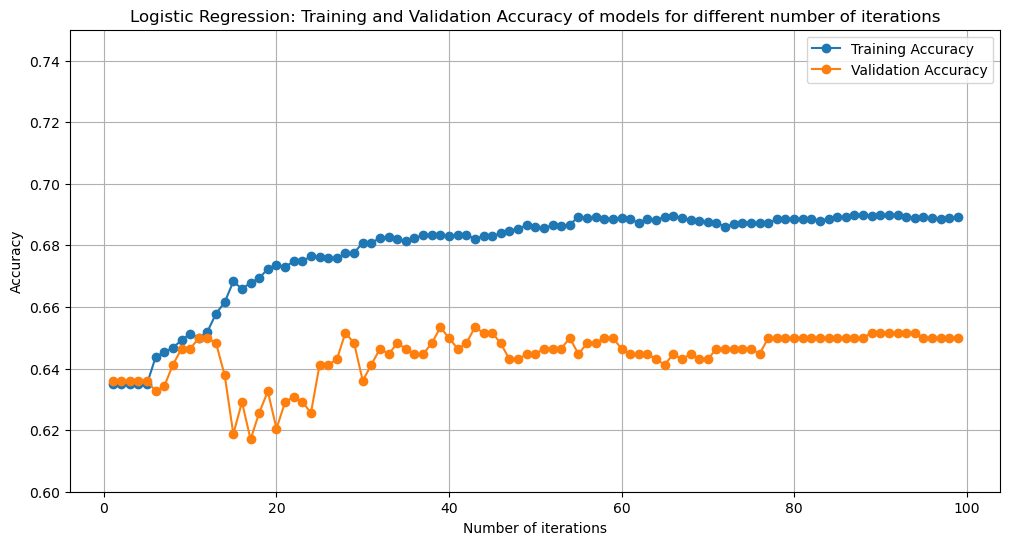

In [24]:
# Plot the learning curve for Logistic Regression
plt.figure(figsize=(12, 6))
plt.plot(max_iters, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_iters, dev_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Logistic Regression: Training and Validation Accuracy of models for different number of iterations')
plt.legend()
plt.ylim(0.6, 0.75)
plt.grid(True)
plt.show()

Accuracy for training set: 0.6638
F1 score for training set: 0.7734
Accuracy for validation set: 0.6412
F1 score for validation set: 0.7800


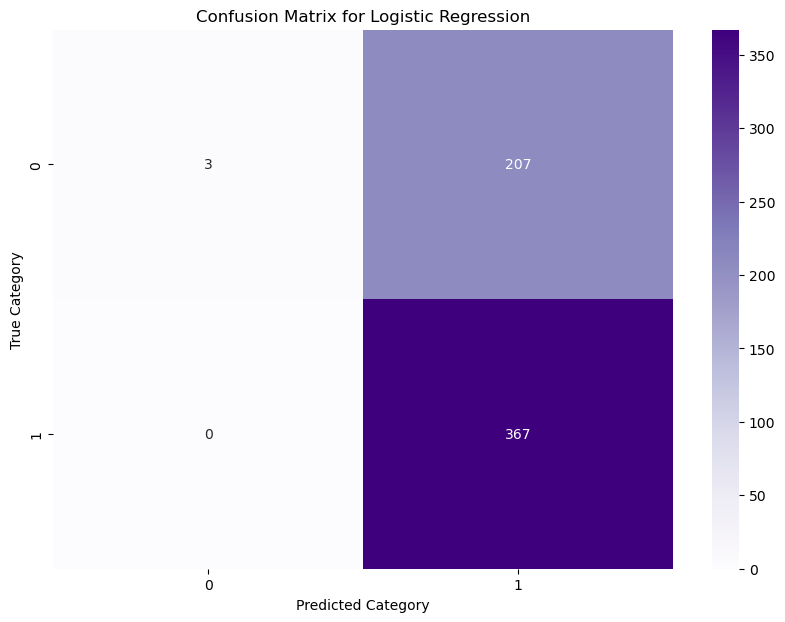

In [25]:
# Use Logistic Regression with best hyperparameters according to f1 score for predicting decisions using information available prior or during 
# court hearing
model = LogisticRegression(max_iter=6, solver='lbfgs', C=0.01)

# Train the logistic Regression on the training data
model.fit(train_x_scaled, train_y)

# Make predictions on the training set
pred_y = model.predict(train_x_scaled)

# Evaluate the model using accuracy and f1 score for training set
accuracy_ll = accuracy_score(train_y, pred_y)
print(f'Accuracy for training set: {accuracy_knn:.4f}')
f1_ll = f1_score(train_y, pred_y)
print(f'F1 score for training set: {f1_knn:.4f}')

# Make predictions on the validation set
pred_y = model.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score for validation set
accuracy_ll = accuracy_score(dev_y, pred_y)
print(f'Accuracy for validation set: {accuracy_ll:.4f}')
f1_ll = f1_score(dev_y, pred_y)
print(f'F1 score for validation set: {f1_ll:.4f}')

# Compute confusion matrix
matrix = confusion_matrix(dev_y, pred_y)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Purples", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ1, dev_x_RQ1], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
model.fit(tune_x_scaled, tune_y)

# Make predictions on the test set
pred_y = model.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file  - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_best_ll_f1.csv', index=False)

Accuracy for training set: 0.6638
F1 score for training set: 0.7734
Accuracy for validation set: 0.6534
F1 score for validation set: 0.7590


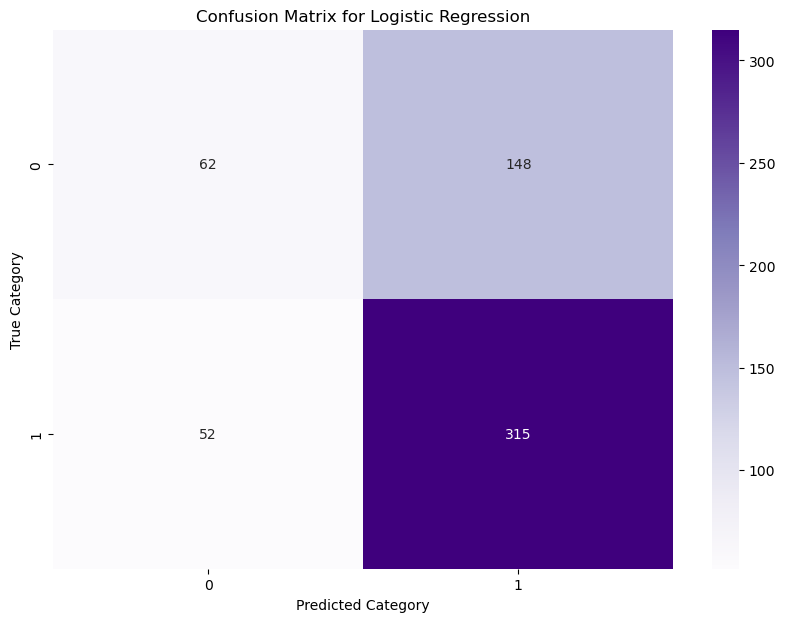

In [26]:
# Use Logistic Regression with best hyperparameters according to accuracy for predicting decisions using information available prior or during 
# court hearing
model = LogisticRegression(max_iter=39, solver='lbfgs', C=1)

# Train the logistic Regression on the training data
model.fit(train_x_scaled, train_y)

# Make predictions on the training set
pred_y = model.predict(train_x_scaled)

# Evaluate the model using accuracy and f1 score for training set
accuracy_ll = accuracy_score(train_y, pred_y)
print(f'Accuracy for training set: {accuracy_knn:.4f}')
f1_ll = f1_score(train_y, pred_y)
print(f'F1 score for training set: {f1_knn:.4f}')

# Make predictions on the validation set
pred_y = model.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score for validation set
accuracy_ll = accuracy_score(dev_y, pred_y)
print(f'Accuracy for validation set: {accuracy_ll:.4f}')
f1_ll = f1_score(dev_y, pred_y)
print(f'F1 score for validation set: {f1_ll:.4f}')

# Compute confusion matrix
matrix = confusion_matrix(dev_y, pred_y)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Purples", xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ1, dev_x_RQ1], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
model.fit(tune_x_scaled, tune_y)

# Make predictions on the training set
pred_y = model.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_best_ll_accuracy.csv', index=False)

The following is for research question 2. 
RQ2: Do the features reflecting the difficulty of cases contribute to prediction of Supreme Court decisions?

Length of hearing is introduced on top of the 200 features selected to investigate this. If improvement can observed when comparing with the model from RQ1, the feature is helpful in predicting Supreme Court decisions. 

In [28]:
# Add 'hearing_length' to all existing dataframes
train_x_RQ2 = pd.concat([train_x_RQ1, train_df[['hearing_length']]], axis=1)
dev_x_RQ2 = pd.concat([dev_x_RQ1, dev_df[['hearing_length']]], axis=1)
test_x_RQ2 = pd.concat([test_x_RQ1, test_df[['hearing_length']]], axis=1)

# Perform normalisation
scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x_RQ2)
dev_x_scaled = scaler.transform(dev_x_RQ2)
test_x_scaled = scaler.transform(test_x_RQ2)

In [29]:
# Calculate Person correlations and thier p-values
train_x_scaled_df = pd.DataFrame(train_x_scaled, columns=train_x_RQ2.columns)
dev_x_scaled_df = pd.DataFrame(dev_x_scaled, columns=dev_x_RQ2.columns)

correlation_coefficient, p_value = pearsonr(train_x_scaled_df['hearing_length'], train_df['successful_appeal'])
print(f'Pearson Correlation Coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

correlation_coefficient, p_value = pearsonr(dev_x_scaled_df['hearing_length'], dev_df['successful_appeal'])
print(f'Pearson Correlation Coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

Pearson Correlation Coefficient: -0.004648547179868687
P-value: 0.7523008937699894
Pearson Correlation Coefficient: 0.030592958337844527
P-value: 0.4632863475831002


In [30]:
# Use KNN with best hyperparameters according to Kaggle result for predicting decisions using information available prior or during court hearing and 
# length of hearing
knn_classifier = KNeighborsClassifier(n_neighbors=20, metric='euclidean', weights='distance')

# Train the k-NN classifier on the training data
knn_classifier.fit(train_x_scaled, train_y)

# Make predictions on the validation set
pred_y = knn_classifier.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score for validation set
accuracy_knn_RQ2 = accuracy_score(dev_y, pred_y)
print(f'Accuracy: {accuracy_knn_RQ2:.4f}')
f1_knn_RQ2 = f1_score(dev_y, pred_y)
print(f'F1 score: {f1_knn_RQ2:.4f}')

# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ2, dev_x_RQ2], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
knn_classifier.fit(tune_x_scaled, tune_y)

# Make predictions on the test set
pred_y = knn_classifier.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_RQ2_knn.csv', index=False)

Accuracy: 0.6551
F1 score: 0.7683


In [31]:
# Use Logistic Regression with best hyperparameters according to Kaggle result for predicting decisions using information available prior or during 
# court hearing and length of hearing
model = LogisticRegression(max_iter=39, solver='lbfgs', C=1)

# Train the logistic Regression on the training data
model.fit(train_x_scaled, train_y)

# Make predictions on the validation set
pred_y = model.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score for validation set
accuracy_ll_RQ2 = accuracy_score(dev_y, pred_y)
print(f'Accuracy: {accuracy_ll_RQ2:.4f}')
f1_ll_RQ2 = f1_score(dev_y, pred_y)
print(f'F1 score: {f1_ll_RQ2:.4f}')


# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ2, dev_x_RQ2], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
model.fit(tune_x_scaled, tune_y)

# Make predictions on the test set
pred_y = model.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_RQ2_ll.csv', index=False)

Accuracy: 0.6412
F1 score: 0.7544


The following is for research question 3. 
RQ3: How does gender of justices affect prediction of accuracy, potentially indicating bias? 

The percentage of female justice in each case is introduced on top of the 200 features selected to investigate this. If improvement can observed when comparing with the model from RQ1, it indicates potential bias in prediction 

In [65]:
# Add 'percent_female' to all existing dataframes
train_x_RQ3 = pd.concat([train_x_RQ1, train_df[['percent_female']]], axis=1)
dev_x_RQ3 = pd.concat([dev_x_RQ1, dev_df[['percent_female']]], axis=1)
test_x_RQ3 = pd.concat([test_x_RQ1, test_df[['percent_female']]], axis=1)

# Perform normalisation
scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x_RQ3)
dev_x_scaled = scaler.transform(dev_x_RQ3)
test_x_scaled = scaler.transform(test_x_RQ3)

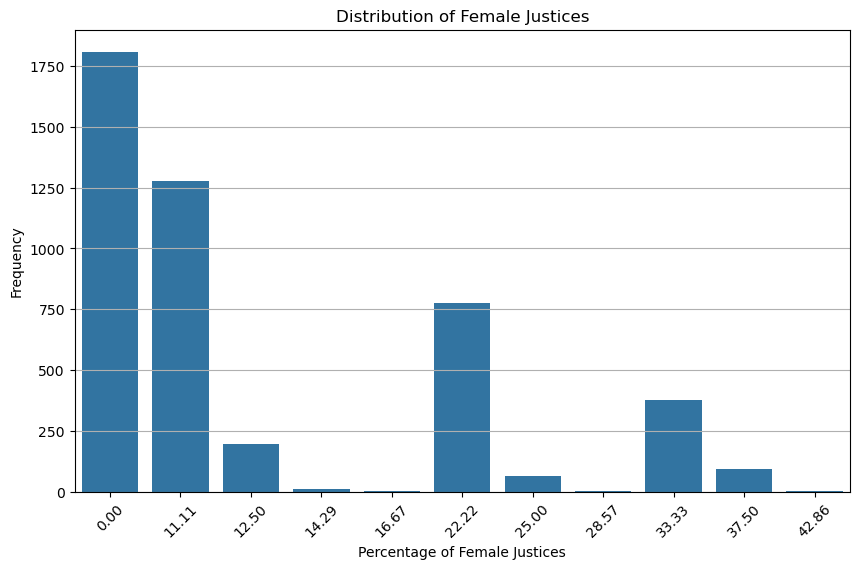

In [67]:
# Plot distribution for female justices to analyse results
# Count occurrences of each unique percentage
count_values = train_df['percent_female'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=count_values.index, y=count_values.values)
plt.title('Distribution of Female Justices')
plt.xlabel('Percentage of Female Justices')
plt.ylabel('Frequency')

# Formatting x-axis labels to show two decimal places
x_labels = [f'{x:.2f}' for x in count_values.index]  # Format x labels
plt.xticks(ticks=bar_plot.get_xticks(), labels=x_labels, rotation=45)  # Set formatted labels

plt.grid(axis='y')
plt.show()



In [69]:
# Use KNN with best hyperparameters according to Kaggle result for predicting decisions using information available prior or during court hearing and 
# percentage of females justices
knn_classifier = KNeighborsClassifier(n_neighbors=20, metric='euclidean', weights='distance')

# Train the k-NN classifier on the training data
knn_classifier.fit(train_x_scaled, train_y)

# Make predictions on the validation set
pred_y = knn_classifier.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score
accuracy_knn_RQ3 = accuracy_score(dev_y, pred_y)
print(f'Accuracy: {accuracy_knn_RQ3:.4f}')
f1_knn_RQ3 = f1_score(dev_y, pred_y)
print(f'F1 score: {f1_knn_RQ3:.4f}')


# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ3, dev_x_RQ3], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
knn_classifier.fit(tune_x_scaled, tune_y)

# Make predictions on the test set
pred_y = knn_classifier.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_RQ3_knn.csv', index=False)


Accuracy: 0.6326
F1 score: 0.7512


In [71]:
# Use Logistic Regression with best hyperparameters according to Kaggle result for predicting decisions using information available prior or during 
# court hearing and percentage of females justices
model = LogisticRegression(max_iter=39, solver='lbfgs', C=1)

# Train the logistic Regression on the training data
model.fit(train_x_scaled, train_y)

# Make predictions on the validation set
pred_y = model.predict(dev_x_scaled)

# Evaluate the model using accuracy and f1 score
accuracy_ll_RQ3 = accuracy_score(dev_y, pred_y)
print(f'Accuracy: {accuracy_ll_RQ3:.4f}')
f1_ll_RQ3 = f1_score(dev_y, pred_y)
print(f'F1 score: {f1_ll_RQ3:.4f}')

# Refine model using combined dataset (training & dev set)
tune_x = pd.concat([train_x_RQ3, dev_x_RQ3], ignore_index=True)
tune_x_scaled = scaler.transform(tune_x)
tune_y = pd.concat([train_y, dev_y], ignore_index=True)
model.fit(tune_x_scaled, tune_y)

# Make predictions on the test set
pred_y = model.predict(test_x_scaled)
output_df = pd.DataFrame({
    'case_id': test_df['case_id'],
    'pred_y': pred_y
})

# Save the DataFrame to a CSV file - the file was submitted to Kaggle for performance evaluation
output_df.to_csv('prediction_RQ3_ll.csv', index=False)

Accuracy: 0.6482
F1 score: 0.7563
